# Smartphone Price model  using MCMC

## Credit 
1) The Dataset was downloaded from Kaggle *Mobile Phones Specifications and Prices in Kenya*  https://www.kaggle.com/datasets/lyraxvinns/mobile-phones-specifications-and-prices-in-kenya

2) https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/getting_started.html

3) https://bpostance.github.io/posts/pymc3-predictions/

4)https://odsc.medium.com/how-bayesian-machine-learning-works-5fd1a746734


# Step 1: Import the basic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split # for spliting data into raining and testing data

In [3]:
import pandas as pd ## Import pandas library for data manipulation

# Step 2: Load the dataset to the platform

The Pandas library has an easy way to load in data, read_csv():

In [4]:
phoneprice = pd.read_csv("datasets/PhonesPriceInKenya.csv")

In order to view the data, how they are arranged we can use the head() function which shows the first 5 rows of data. To see the last five we use iris.head(-5)

In [5]:
phoneprice.head()

,Phone Title,Specs,Price(Kshs),Rating,Specs Score,Likes
0,Gionee M7 Power,"Screen:6.0 inches, 720 x 1440 pixels,Front Cam...","11,800",4.0,56%,13
1,Gionee M7,"Screen:6.01 inches, 1080 x 2160 pixels,Front C...","7,999",4.5,69%,8
2,Samsung Galaxy M21 6GB128GB,"Screen:6.4 inches, 1080 x 2340 pixels,Front Ca...","22,590",4.3,100%,30
3,Samsung Galaxy M21 4GB64GB,"Screen:6.4 inches, 1080 x 2340 pixels,Front Ca...","22,499",3.8,94%,31
4,Samsung Galaxy A31 6GB128GB,"Screen:6.4 inches, 1080 x 2400 pixels,Front Ca...","24,999",3.8,98%,31


## Step2: Preprocessing and Data Cleaning 
This data has comma separator in the **Price(Kshs)** and % sign in the **Specs Score** which is not regognized as interger,rather the dataframe sees the entry as a string. We use DataFrame.replace with regex=True for substrings replacement
1)We need to remove all the commas from the **Price(Kshs)**  

2)Remove the % sign from **Specs Score**

In [6]:
phoneprice['Price(Kshs)'] = phoneprice['Price(Kshs)'].replace(',','', regex=True)
phoneprice['Specs Score'] = phoneprice['Specs Score'].replace('%','', regex=True)
# phoneprice

select all rows with NaN values in Pandas DataFrame  Using isnull() to select all rows with NaN under a single DataFrame column

In [7]:
phoneprice[phoneprice['Price(Kshs)'].isnull()].count()

Phone Title    78
Specs          78
Price(Kshs)     0
Rating         78
Specs Score    78
Likes          78
dtype: int64

Convert all the numeric series to float datatype. This is to avoid situations that the entries are read as string

In [8]:
all_numeric_series = ['Price(Kshs)','Rating','Specs Score','Likes']
phoneprice[all_numeric_series] = phoneprice[all_numeric_series].astype(float)

Find the mean of the enries and use it to fill the NAN entries

In [9]:
mean_value_for_all = phoneprice[all_numeric_series].mean()
mean_value_for_all

Price(Kshs)    20453.197196
Rating             3.934408
Specs Score       67.733449
Likes             25.145470
dtype: float64

## Data Cleaning: Filling the missing values

In [10]:
[phoneprice.fillna(value=mean_value_for_all, inplace=True)]
phoneprice.isna().any() # Check if there are any null values

Phone Title    False
Specs          False
Price(Kshs)    False
Rating         False
Specs Score    False
Likes          False
dtype: bool

In [11]:
#Remove Outliers
phoneprice2 = phoneprice[(phoneprice[['Price(Kshs)']] >= 100).all(axis=1)]

Check the statistics of the dataset with the **describe()** function e.g the mean, max etc

In [12]:
phoneprice2.describe()

,Price(Kshs),Rating,Specs Score,Likes
count,1146.000000,1146.000000,1146.000000,1146.000000
mean,20488.745533,3.935166,67.733857,25.178883
std,26489.027599,0.757422,22.378948,32.173741
min,299.000000,1.300000,8.000000,1.000000
25%,1699.000000,3.400000,52.000000,7.000000
50%,13389.500000,4.000000,62.000000,14.000000
75%,24374.250000,4.500000,92.000000,29.750000
max,170000.000000,5.000000,100.000000,296.000000


/Users/ednamilgo/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


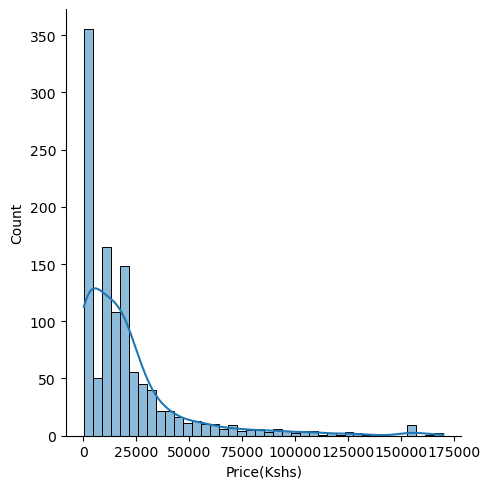

In [13]:
sns.displot(data=phoneprice2,x='Price(Kshs)',kde=True);


# Step 3: Define the inputs and outputs

We now need to define the **features(inputs** and **labels(outputs)**. We can do this easily with pandas by slicing the data table and choosing certain rows/columns.

**input/features** are those characteristics of the data that determines the class that they belong e.g color, lenght, weight etc

**output** is the class that they belong e.g positive/negative, 0/1, hot/cold, present/absent etc

You can achieve this by naming all the column names within a double square parenthesis.

Another way to do this using **iloc()**


In [14]:
# Let's tell the dataframe which column we want for the imputs/features.  
X = phoneprice2[['Rating','Specs Score','Likes']]

# Let's tell the dataframe which column we want for the target/labels/output.  
y = phoneprice2[['Price(Kshs)']]

# Step 4: Split the data to training and testing sets. 
Remember the default percentage is 80% for training and 20% for testing but you can change the percentages using test_size

Assign the split data into diffent arrays

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

# Step 5: Create a PYMC3 model

In [16]:
#We are going to use only three columns to train the data
X1 = X_train['Rating']
X2 = X_train['Specs Score']
X3 = X_train['Likes']

### Create a model called phoneprice_model  which stores all our variables for this model
The prior distributions is a Normal distribution:

 with $\alpha, \beta, \sigma$

In [17]:
X_train=np.array([X1,X2,X3])
y_train=np.array(y_train)

In [18]:
type(X_train)

numpy.ndarray

### Specify the prior and likelihood for the model

In [19]:
import pymc3 as pm  # This is the framework

with pm.Model() as phoneprice_model:
   # Priors for unknown model parameters
    alpha = pm.Normal('intercept', mu=14, sigma=10)# alpha is the y-intercept
    beta = pm.Normal('coeff', mu=0, sigma=10,shape=X_train.shape[1])# The coefficients of each of the variables
    sigma = pm.HalfNormal('sigma', sigma=10) # standard deviation of the observations

    price = alpha + pm.math.dot(X_train, beta)# Equation for the prior


    # Likelihood/sampling distribution of observations
    Y_obs = pm.Normal('Y_obs', mu=price, sigma=sigma, observed=y_train)


##  Metropolis Sampler

In [20]:
with phoneprice_model:
    price_trace = pm.sampling.sample(draws=10000, step=pm.Metropolis(), chains=2,init='auto', tune=1000, 
                                     discard_tuned_samples=True, compute_convergence_checks=True)


/var/folders/8_/hd0tkl1d2jnbwbkkgd0ql1_h0000gn/T/ipykernel_12871/1635790908.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  price_trace = pm.sampling.sample(draws=10000, step=pm.Metropolis(), chains=2,init='auto', tune=1000,
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [coeff]
>Metropolis: [intercept]
/Users/ednamilgo/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/Users/ednamilgo/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 47 seconds.
/Users/ednamilgo/opt/anaconda3/lib/python3.9/site-packages/arviz/utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


###  Summary statistics from the estimates

In [21]:
import arviz as az  #Works with Pymc3 for plotting and data storage 
with phoneprice_model:
    display(az.summary(price_trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,53.66,24.98,15.68,102.73,13.93,10.91,3.34,31.38,1.60
coeff[0],23.40,5.85,11.00,31.67,3.09,2.51,3.44,28.43,1.63
coeff[1],10.43,10.44,-8.36,28.40,6.20,4.93,2.98,21.65,1.83
coeff[2],2.27,8.38,-10.74,16.40,4.23,3.25,4.60,10.77,1.45
coeff[3],5.50,7.05,-10.29,17.24,4.30,3.45,2.55,13.44,2.18
...,...,...,...,...,...,...,...,...,...
coeff[912],13.37,7.24,0.33,25.06,4.35,3.50,2.82,24.36,1.92
coeff[913],-9.16,8.99,-24.46,7.26,5.54,4.56,2.71,10.88,2.01
coeff[914],-6.12,15.01,-34.32,15.37,10.10,8.38,2.32,10.88,2.74
coeff[915],-9.81,4.83,-18.30,-1.85,2.57,1.99,3.73,26.92,1.49


###  Trace plots for the parameters

/Users/ednamilgo/opt/anaconda3/lib/python3.9/site-packages/arviz/utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


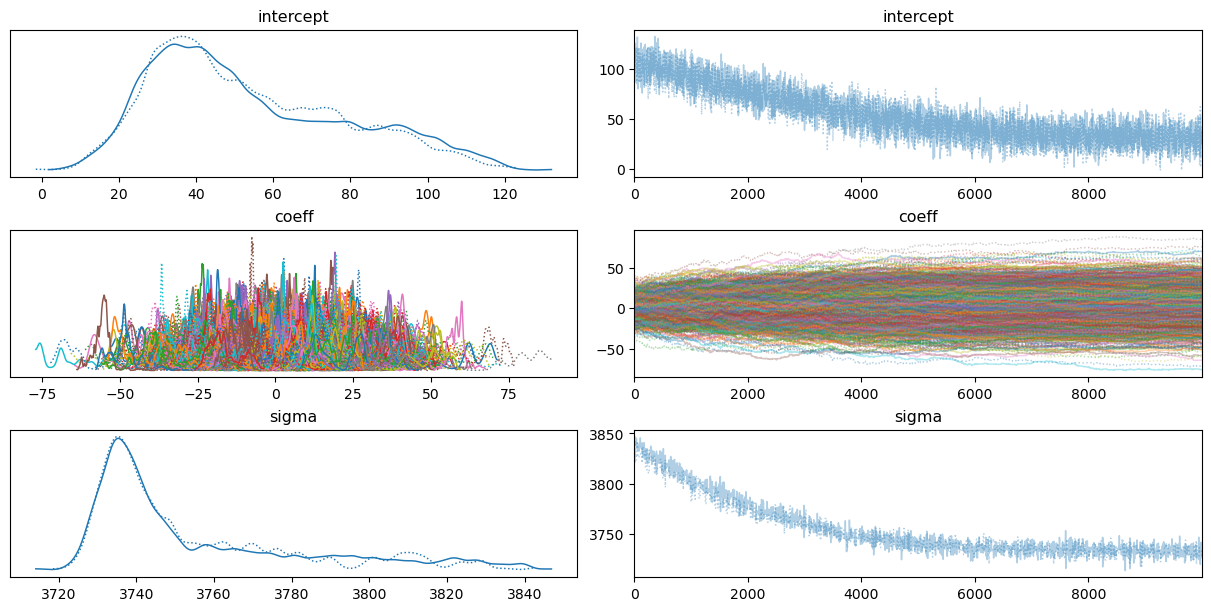

In [22]:
with phoneprice_model:
    az.plot_trace(price_trace);